## In this notebook, we will be covering the entire premodeling phase
Premodeling is the process of making further transformations to our data so that it is best-suited for training and evaluating a machine learning model

In [1]:
import pandas as pd
import numpy as np
import datetime 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
from itertools import combinations
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedKFold
from sklearn.linear_model import Lasso, LogisticRegression

from sklearn.decomposition import PCA
from sklearn import ensemble, tree, metrics

# start where we stopped last time
equity_data = pd.read_csv("C:/Users/lbianculli/dev/us_equities/python_processes/us_data_final2.csv").drop("Unnamed: 0", axis=1)
equity_data["date_dt"] = pd.to_datetime(equity_data["period"], format='%Y-%m-%d')


Define a function that will allow us to label our data. In this case, we are concerned with whether the next periods free cash flow will be in the top quantile.

In [2]:
def feature_deltas(df, feature, classification=True, current_period="2021-6"):  
    """ 
    Get period-over-period changes for a collection of features and return the updated DF 
    df: Pandas DataFrame of data inclusive of 'features' columns
    features: columns of DataFrame for which individual deltas will be calculated
    freq: Frequency of resampling period
    classification: Whether this data is to be used for a classification problem
    """
    feature_dfs = []
    tmp = []
    tickers = []
    current_data = []
    
    feature_vals = pd.pivot_table(df, values=feature, index="date_dt", columns=["ticker"])  # pivot on specified feature

    # we pivoted with tickers in columns. Now we iterate through them
    for ticker in feature_vals.columns:
        # Get just ticker, date, and feature
        feature_series = feature_vals[ticker].dropna().reset_index()
        feature_series.columns = ["date", f"{feature}"]

        # downsample data to quarterly (as that is the fundamental data's frequency)
        downsampled = feature_series.set_index("date").resample("Q").mean().reset_index()

        # fill NaNs with mean and calculate next period's measure
        downsampled = downsampled.fillna(value=downsampled[feature].mean())
        downsampled[f"next_{feature}"] = downsampled[f"{feature}"].shift(-1)

        # get year, month, day
        downsampled["year"] = downsampled["date"].dt.year
        downsampled["month"] = downsampled["date"].dt.month
        downsampled["day"] = downsampled["date"].dt.day

        # convert to strings for ID
        downsampled["year"] = downsampled["year"].astype(str)
        downsampled["month"] = downsampled["month"].astype(str)
        downsampled["day"] = downsampled["day"].astype(str)
        downsampled["period"] = downsampled["year"] + "-" + downsampled["month"]

        tickers.append([ticker] * downsampled.shape[0])

        # append individual ticker data for given feature
        tmp.append(downsampled)

    # consildate feature data and calculate quantile
    feature_data = pd.concat([df for df in tmp], axis=0).reset_index(drop=True)
    feature_data[f"{feature}_quantile"] = pd.qcut(feature_data[f"{feature}"].rank(method='first'), q=5, labels=False) + 1
    feature_data[f"next_{feature}_quantile"] = pd.qcut(feature_data[f"next_{feature}"].rank(method='first'), q=5, labels=False) + 1
    feature_dfs.append(feature_data.drop([f"{feature}_quantile", f"next_{feature}"], axis=1))

    tickers = [ele for sub in tickers for ele in sub]
    
    # consolidate dfs for all features
    feature_data = pd.concat([df for df in feature_dfs], axis=0).reset_index(drop=True)
    feature_data["ticker"] = tickers
    feature_data["date_str"] = feature_data["date"].dt.strftime("%Y-%m-%d")
    feature_data["id"] = feature_data["ticker"] + "-" + feature_data["period"]

    final_historical = feature_data.drop(["ticker","year", "month", "day", "ticker"], axis=1)
    
    return final_historical


def get_sample_weights(labels):
    """ returns array of normalized sample weight array for use in classifier.fit() """
    from sklearn.utils.class_weight import compute_sample_weight
    class_weights = {}
    unique_labels = np.unique(labels)
    total_label_count = labels.shape[0]

    # get inverted weights
    for class_ in unique_labels:
        label_count = labels[labels==class_].shape[0]
        label_weight = 1 / (label_count / total_label_count)
        class_weights[class_] = label_weight

    total_class_weight = sum(class_weights.values())
    upd_class_weights = {}

    # normalize weights
    for class_ in class_weights.keys():
        upd_class_weights[class_] = class_weights[class_] / total_class_weight

    sample_weights = compute_sample_weight(upd_class_weights, labels)

    return sample_weights

def dict_product(dict_):  # very cool
    """
    returns generator of all key-value pairs in input dict as separate dicts
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    from itertools import product
    return (dict(zip(dict_, x)) for x in product(*dict_.values()))

We will split out the current data from the rest of the data so that we can use that to evalute would-be performance of the model.

In [3]:
# Note 10Qs generally release at the end of the following month. e.g. June financials will be disseminated End of July

current_period = "2021-6"
equity_data["ev_to_ebitda"] = np.where(equity_data["ev_to_ebitda"] < 0, 100, equity_data["ev_to_ebitda"])

# get YoY changes for desired features and merge with original dataset on those dates/tickers
delta_data = feature_deltas(df=equity_data, feature="fcf_per_share")

# get label and drop redundant columns
delta_data["label"] = np.where(delta_data["next_fcf_per_share_quantile"] == 5, 1, -1)
delta_data = delta_data.drop(["fcf_per_share", "next_fcf_per_share_quantile"], axis=1)

# split out current data
current_data = delta_data.loc[delta_data["period"] == current_period]
final_historical = delta_data.drop(current_data.index)

# split out the rest of the data
analysis_data = final_historical.merge(equity_data, left_on="id", right_on="id", how="left").dropna()
current_data = current_data.merge(equity_data, left_on="id", right_on="id", how="left").dropna()

# drop unneeded cols
analysis_data = analysis_data.drop(["date_str", "period_x"], axis=1)
current_data = current_data.drop(["date_str", "period_x"], axis=1)

print(f"Analysis data has {analysis_data.shape[0]} rows.")

premodel_data = analysis_data.drop(["ticker", "period_y", "date", "date_dt", "id", "1mo_fwd_rets", 
                                    "1mo_fwd_log_rets", "1mo_log_rets"], axis=1)
current_data = current_data.drop(["period_y", "date", "date_dt", "id", "1mo_fwd_rets", 
                                    "1mo_fwd_log_rets", "1mo_log_rets"], axis=1)

Analysis data has 36430 rows.


In [4]:
# write out current data so we can evaluate after the quarter end
current_tickers = current_data.loc[current_data["label"] == 1]
current_tickers.to_csv("current_tickers.csv")
len(current_tickers), premodel_data["label"].mean()

(2, -0.5865495470765852)

Lets define our Premodel class that will allow us to do various premodeling stops including splitting into train and test data, running SKLearn grid searches, and examine feature importance

In [5]:
class Premodel:
    plt.rcParams['figure.figsize'] = (8.0, 5.0)

    def __init__(self, data):
        self.data = data
    
    def train_test_split(self, label, train_size=.8):
        """ 
        Split processed data into train and test sets. Extract labels. Also stores indexed labels and data in the process.
        Data is required to have the label_col column that represents train and test labels.
        """
        # Carve out holdout data
        holdout = self.data.sample(frac=.2)
        non_holdout_data = self.data.drop(holdout.index, axis=0)
        holdout_labels = holdout[label] 
        holdout_data = holdout.drop([label], axis=1)

        # split out train and test from non-holdout data
        labeled_train_data = non_holdout_data.sample(frac=.8)
        labeled_test_data = non_holdout_data.drop(labeled_train_data.index)

        train_data = labeled_train_data.drop([label], axis=1).reset_index(drop=True)
        train_labels = labeled_train_data[label].reset_index(drop=True)

        test_data = labeled_test_data.drop([label], axis=1).reset_index(drop=True)
        test_labels = labeled_test_data[label].reset_index(drop=True)

        # normalize data
        scaler = StandardScaler()
        normed_train_data = scaler.fit_transform(train_data)
        normed_test_data = scaler.transform(test_data)
        normed_holdout_data = scaler.transform(holdout_data)
        
        normed_train_data = pd.DataFrame(data=normed_train_data, columns=[c for c in self.data.columns if c != "label"])
        assert("label" not in normed_train_data.columns)

        normed_test_data = pd.DataFrame(data=normed_test_data, columns=[c for c in self.data.columns if c != "label"])
        
        normed_holdout_data = pd.DataFrame(data=normed_holdout_data, columns=[c for c in self.data.columns if c != "label"])

        return normed_train_data, normed_test_data, normed_holdout_data, train_labels, test_labels, holdout_labels

    def pca_transform(self, train_data, test_data, n_components):
        """ take train data and apply PCA. We do this so we always train on the same records """
        pca = PCA(n_components)
        pca_train_data = pca.fit_transform(train_data)
        pca_test_data = pca.fit_transform(test_data)

        return pca_train_data, pca_test_data, pca
    

    def run_grid(self, clf, grid, train_data, test_data, train_labels, test_labels, n_jobs=-1, score="accuracy"):
        """ 
        Runs SKLearn implementation of grid search 
        clf: un-fit SKLearn classifier
        grid: params upon which grid search will run
        data: pandas DataFrame of model data, inclusive of label
        label: name of column that holds classification labels

        returns: Most accurate model
        """
        grid_search = GridSearchCV(estimator=clf, param_grid=grid, n_jobs=n_jobs, scoring=score)
        best_clf = grid_search.fit(train_data, train_labels).best_estimator_

        # get model predictions and accuracy
        preds = best_clf.predict(test_data)
        acc = metrics.accuracy_score(preds, test_labels)

        print(f"Model Accuracy: {acc*100:.1f}%")

        return best_clf

## Measuring Interactions

Before moving onto feature selection, we are going to take a look at interactions between variables in our feature space. Once we are done examining features, we will keep the ones with the largest difference between feature quantiles

In [6]:
def plot_interaction(df, x, x2, label):
    """
    Plots the probability of increase of the label at the cross-sectional performance of variables x and x2
    df: pandas dataframe containing columns with independent vars and labels
    x: column name of an independent variable within the dataframe
    x2: column name of a second independent variable within the dataframe
    label: column name of the label in which we are concerned
    x_buckets: number of buckets into which we split the primary x variable 
    x2_buckets: number of buckets into which we split the secondary x variable 
    
    returns plot and constructed dataframe
    """
    plt.rcParams['figure.figsize'] = (10.0, 6.0)
    df2 = df.copy()
    # get quantiles of variables
    df2[f"{x}_quantile"] = pd.qcut(df2[x].rank(method='first'), q=4, labels=False) + 1
    df2[f"{x2}_quantile"] = pd.qcut(df2[x2].rank(method='first'), q=3, labels=False) + 1

    # bucket into high, med, low groups based on x2
    high_x2 = df2.loc[df2[f"{x2}_quantile"] == 3]
    mid_x2 = df2.loc[df2[f"{x2}_quantile"] == 2]
    low_x2 = df2.loc[df2[f"{x2}_quantile"] == 1]

    # get probs of increase given high x2
    p_increase_very_high_x_high_x2 = high_x2.loc[high_x2[f"{x}_quantile"] == 4][label].value_counts().loc[1] / \
                                    high_x2.loc[high_x2[f"{x}_quantile"] == 4].shape[0]
    p_increase_high_x_high_x2 = high_x2.loc[high_x2[f"{x}_quantile"] == 3][label].value_counts().loc[1] / \
                                    high_x2.loc[high_x2[f"{x}_quantile"] == 3].shape[0]
    p_increase_low_x_high_x2 = high_x2.loc[high_x2[f"{x}_quantile"] == 2][label].value_counts().loc[1] / \
                                    high_x2.loc[high_x2[f"{x}_quantile"] == 2].shape[0]
    p_increase_very_low_x_high_x2 = high_x2.loc[high_x2[f"{x}_quantile"] == 1][label].value_counts().loc[1] / \
                                    high_x2.loc[high_x2[f"{x}_quantile"] == 1].shape[0]
    high_x2_data = [p_increase_very_low_x_high_x2, p_increase_low_x_high_x2, p_increase_high_x_high_x2, p_increase_very_high_x_high_x2]

    # get probs of increase given mid x2
    p_increase_very_high_x_mid_x2 = mid_x2.loc[mid_x2[f"{x}_quantile"] == 4][label].value_counts().loc[1] / \
                                    mid_x2.loc[mid_x2[f"{x}_quantile"] == 4].shape[0]
    p_increase_high_x_mid_x2 = mid_x2.loc[mid_x2[f"{x}_quantile"] == 3][label].value_counts().loc[1] / \
                                    mid_x2.loc[mid_x2[f"{x}_quantile"] == 3].shape[0]
    p_increase_low_x_mid_x2 = mid_x2.loc[mid_x2[f"{x}_quantile"] == 2][label].value_counts().loc[1] / \
                                    mid_x2.loc[mid_x2[f"{x}_quantile"] == 2].shape[0]
    p_increase_very_low_x_mid_x2 = mid_x2.loc[mid_x2[f"{x}_quantile"] == 1][label].value_counts().loc[1] / \
                                    mid_x2.loc[mid_x2[f"{x}_quantile"] == 1].shape[0]
    mid_x2_data = [p_increase_very_low_x_mid_x2, p_increase_low_x_mid_x2, p_increase_high_x_mid_x2, p_increase_very_high_x_mid_x2]

    # xs given low y
    p_increase_very_high_x_low_x2 = low_x2.loc[low_x2[f"{x}_quantile"] == 4][label].value_counts().loc[1] / \
                                    low_x2.loc[low_x2[f"{x}_quantile"] == 4].shape[0]
    p_increase_high_x_low_x2 = low_x2.loc[low_x2[f"{x}_quantile"] == 3][label].value_counts().loc[1] / \
                                    low_x2.loc[low_x2[f"{x}_quantile"] == 3].shape[0]
    p_increase_low_x_low_x2 = low_x2.loc[low_x2[f"{x}_quantile"] == 2][label].value_counts().loc[1] / \
                                    low_x2.loc[low_x2[f"{x}_quantile"] == 2].shape[0]
    p_increase_very_low_x_low_x2 = low_x2.loc[low_x2[f"{x}_quantile"] == 1][label].value_counts().loc[1] / \
                                    low_x2.loc[low_x2[f"{x}_quantile"] == 1].shape[0]
    low_x2_data = [p_increase_very_low_x_low_x2, p_increase_low_x_low_x2, p_increase_high_x_low_x2, p_increase_very_high_x_low_x2]

    # get probs of increase given low x2
    data = high_x2_data + mid_x2_data + low_x2_data
    y_labels = [f"high {x2}"] * 4 + [f"mid {x2}"] * 4 + [f"low {x2}"]*4
    x_labels = ["Very low", "Low", "High", "Very high"] * 3

    tmp = pd.DataFrame(data, columns=["data"])
    tmp["y_labels"] = y_labels
    tmp["x_labels"] = x_labels

    ### PLOTTING
    fig, ax = plt.subplots()
    
    # aesthetics
    sns.set_style("whitegrid");
    palette = sns.color_palette(["#55a868", "#4c72b0", "#c44e55"])

    # Create Labels
    plt.ylabel("Probability")
    plt.xlabel(x.replace("_", " ").upper())
    plt.title(f"Prob. of positive change in {label.upper()} given {x.replace('_', ' ').upper()} and {x2.upper()}")

    # Plot
    g = sns.lineplot(data=tmp, y="data", x="x_labels", hue="y_labels", ax=ax, palette=palette)
    ax.legend([f"High", f"Medium", f"Low"]).set_title(f"{x2.replace('_', ' ').upper()} Label")

    plt.show()
    
def measure_interactions(df, x, x2, label, x_buckets=3, x2_buckets=4, threshold=100):
    """ 
    Measures the difference between interactions according to the predictive power of various buckets
    df: pandas DataFrame containing columns x, x2, and label
    x: name of first variable whose interaction we are interested in
    x2: name of second variable whose interaction we are interested in
    label: name of label column we will use to judge interactions
    x_buckets: number of buckets used to measure x
    x2_buckets: number of buckets used to measure x2
    
    returns: sum of differences between buckets and those sequentially lower (for those which it applies)
    --> e.g. buckets 3-2, 3-1, and 2-1 
    """
    quantile_data = {}  # store percent of positive labels for each intersection
    df2 = df.copy()

    # get quantiles of x and x2 variables
    df2[f"{x}_quantile"] = pd.qcut(df2[x].rank(method='first'), q=x_buckets, labels=False) + 1
    df2[f"{x2}_quantile"] = pd.qcut(df2[x2].rank(method='first'), q=x2_buckets, labels=False) + 1
    q_data = df2[[f"{x}_quantile", f"{x2}_quantile", label]]

    for i in range(1, x_buckets+1):
        # split data into buckets along x1 variable
        i_data = q_data.loc[q_data[f"{x}_quantile"] == i]

        for j in range(1, x2_buckets+1):
            # split x1 bucket data according to x2 buckets
            j_data = i_data.loc[i_data[f"{x2}_quantile"] == j]
            try:
                positive_labels = j_data[label].value_counts()[1]
                negative_labels = j_data[label].value_counts()[-1]

                # if not enough observations, skip over
                if (positive_labels < threshold) or (negative_labels < threshold):
                    pass
                else:
                    quantile_data[j] = positive_labels / negative_labels 

            except KeyError as e: 
#                 e.g. all 1000 observations of high "x" correspond to low/medium "x2"
#                 print(f"{x} and {x2} showing only negative labels")  
                pass  

    # get differences (H-M, H-L, and so on)
    diffs = []

    # only examine the relationship if we have enough obs at each quantile
    if len(quantile_data.keys()) < x2_buckets:
        pass
    else: 
        for n in list(quantile_data.keys())[::-1]:
            if n > 1:
                # for each quantile, get individual values by subtracting all lower quantiles
                try:
                    for n2 in range(1, n)[::-1]:
                        diffs.append(quantile_data[n] - quantile_data[n-n2])

                except KeyError as e:
                    pass
                
    return sum(diffs)

def add_interactions(df, col_names):
    """ 
    Calculate interactions between specified columns
    df: pandas DataFrame with input data
    col_names: columns whose interactions we are interested in calculating
    
    returns: pandas DataFrame containing interaction calculations
    """
    # get column names corresponding to the top n ineractions -- should be 2n
    # get individual factors into flat list
    col_names_stacked = [x.split("-") for x in col_names]
    col_names_flat = [ele for sublist in col_names_stacked for ele in sublist]

    # filter dataframe on just the columns in which we are interested
    interaction_data = df[col_names_flat]

    # get final list of columns
    combos = list(combinations(list(interaction_data.columns), 2))
    col_names_final = list(interaction_data.columns) + ['-'.join(x) for x in combos]

    # calc interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    tmp = poly.fit_transform(interaction_data)

    # filter to just the data we are interested in
    interaction_data = pd.DataFrame(tmp, columns=col_names_final)
    interaction_data = interaction_data[col_names]
    non_dupe_data = interaction_data.loc[:,~interaction_data.columns.duplicated()]
    
    return non_dupe_data.merge(df, left_index=True, right_index=True)

Now that the functions are defined to examine the interactions, lets run our data through them

In [7]:
# look at the top interactions according to differences across buckets
interactions = {}

# get all combos and iterate through 
combos = list(combinations(list(premodel_data.drop(["label"], axis=1).columns), 2))
for combo in combos:
    x = combo[0]
    x2 = combo[1]
    
    # for each combination of features, measure the interaction
    interactions[f"{x}-{x2}"]  = measure_interactions(premodel_data.copy(deep=True), 
                                                      x=x, x2=x2, label="label", x_buckets=3)
    
# sort dict by values to we can take the interactions with the most extreme differences.
interactions = list({k: v for k, v in sorted(interactions.items(), key=lambda item: item[1])}.keys())

# arbitrary: we're going to keep top 10 interaction
bot = interactions[:5]
top = interactions[-5:]

# add interactions to our data according to largest differences
int_premodel_data = add_interactions(premodel_data, top+bot)
top

['book_value_per_share-price_to_book_value',
 'capital_expenditure-earnings_per_diluted_share',
 'capital_expenditure-earnings_per_basic_share',
 'price_to_book_value-tangible_assets_book_value_per_share',
 'profit_margin-sales_per_share']

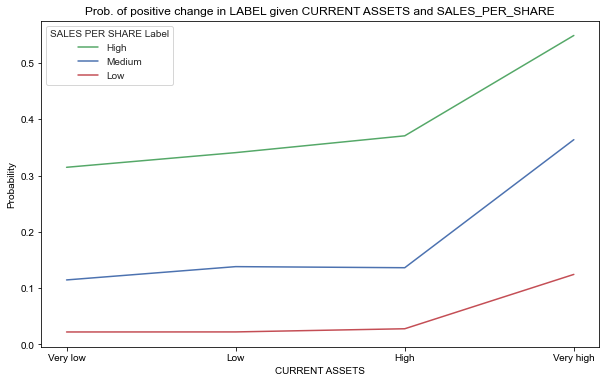

In [8]:
# Visualize a top interaction
plot_interaction(int_premodel_data, x="current_assets", x2="sales_per_share", label="label")

## Feature Importance

The method we will use to detect feature importance is mean decrease accuracy (MDA), which is a form of backward selection.
We will start by defining a class that will have methods allowing us to robustly determine feature importance according to MDA.

For more info on stepwise feature selection: https://en.wikipedia.org/wiki/Stepwise_regression

In [9]:
class FeatureImportance:
    def __init__(self, clf, train_data, train_labels):
        self.clf = clf
        self.data = train_data
        self.labels = train_labels
        self.sample_weights = get_sample_weights(train_labels)
        
    def cv_score(self, data, labels, sample_weights, n_splits=5, score_type="neg_log_loss", all_times=None, cv=None):
        """ 
        Implement CV to handle current bugs in SKlearn (scoring w classes). 
        """
        if score_type not in ["neg_log_loss", "accuracy"]:
            raise Exception("Scoring method not allowed. Try neg_log_loss or accuracy")

        from sklearn.metrics import log_loss, accuracy_score
        scores = []

        if cv is None:
            from sklearn.model_selection import KFold
            cv = KFold(n_splits=n_splits)

        for train, test in cv.split(data, labels):  # use sklearn generator for KFold CV
            fit = self.clf.fit(data.iloc[train], labels.iloc[train], sample_weight=sample_weights[train])  # no iloc for weights b/c it's an array

            if score_type == "neg_log_loss":
                probs = fit.predict_proba(data.iloc[test])
                score_ = -log_loss(labels.iloc[test], probs, sample_weight=sample_weights[test], labels=clf.classes_)  # classes_?

            else:
                preds = fit.predict(data.iloc[test])
                score_ = accuracy_score(labels.iloc[test], preds, sample_weight=sample_weights[test])

            scores.append(score_)

        return np.array(scores)
    
    def feature_mda(self, clf, data, labels, sample_weights, cv=None, n_splits=5, score_type="neg_log_loss"):
        """ 
        OOS feature importance. Similar to the cv_score above. Can use purged or un-purged (bootstrapped) self.data 
        Note that unlike MDI, MDA requires an unfit classifier. Returns DF of mean impurity and std for each feature, 
        as well as the mean train score. Each feature's importance is a function of its loss in performance caused by its columns permutation.
        Note: this can usefully be applied to meta-labeling by specifying 'f1' as the score_type
        """
        # feature importance based on OOS score reduction. B/c it is OOS-based, it is possible that MDA concludes that all features are unimportant
        if score_type not in ["neg_log_loss", "accuracy", "f1"]:
            raise Exception("Scoring method not allowed. Try neg_log_loss or accuracy")

        from sklearn.metrics import log_loss, accuracy_score
        if cv is None:
            from sklearn.model_selection import KFold
            cv = KFold(n_splits=n_splits)

        scores0 = pd.Series(dtype=np.float64)
        scores1 = pd.DataFrame(columns=data.columns)
        for i, (train, test) in enumerate(cv.split(data, labels)):      
            # first: get splits and fit classifier
            x0, y0, w0 = data.iloc[train], labels.iloc[train], sample_weights[train]  # remember, self.sample_weights is an array
            x1, y1, w1 = data.iloc[test], labels.iloc[test], sample_weights[test]
            fit = clf.fit(x0, y0, sample_weight=w0)

            # second: get performance scores (and store)
            if score_type == "neg_log_loss":
                probs = fit.predict_proba(data.iloc[test])
                scores0.loc[i] = -log_loss(labels.iloc[test], probs, sample_weight=sample_weights[test], labels=clf.classes_) 

            else:
                preds = fit.predict(data.iloc[test])
                scores0.loc[i] = accuracy_score(labels.iloc[test], preds, sample_weight=sample_weights[test])

            # shuffle (permutate) each column of the feature matrix one at a time to derive the OOS performance after each permutation
            for j in scores1.columns:
                x1_ = x1.copy(deep=True)
                np.random.shuffle(x1_[j].values)  # get permutation of a single col. np must align indicies automatically.

                if score_type == "neg_log_loss":
                    probs = fit.predict_proba(x1_)
                    scores1.loc[i, j] = -log_loss(y1, probs, sample_weight=w1, labels=clf.classes_)  

                else:
                    preds = fit.predict(x1_)
                    scores1.loc[i, j] = accuracy_score(y1, preds, sample_weight=w1)

        importance = (-scores1).add(scores0, axis=0) 
        if score_type == "neg_log_loss":
            importance /= -scores1
        else:
            importance /= (1.0 - scores1)

        importance_std = importance.std()*importance.shape[0]**-.5
        importance = pd.concat({"imp_mean": importance.mean(), "imp_std": importance_std}, axis=1)

        return importance.sort_values("imp_mean", ascending=False), scores0.mean()


    def _get_eigen_vec(self, dot, var_threshold):  
        """ 
        compute eigenvector of a feature matrix from the dot product matrix, reduce dimension 
        dot: dot products of feature space
        var_threshold: threshold of cumulative variance we wish to capture
        
        returns: eigenvalues and eigenvector
        """
        e_val, e_vec = np.linalg.eigh(dot) # dict as mapping will work as long as these dont shuffle

        idx = e_val.argsort()[::-1] 
        e_val, e_vec = e_val[idx], e_vec[:, idx]

        # # only positive eigenvalues
        e_val = pd.Series(e_val, index=[i for i in range(e_val.shape[0])])  
        e_vec = pd.DataFrame(data=e_vec, index=dot.index, columns=e_val.index)
        e_vec = e_vec.loc[:, e_val.index]

        # reduce dimension, form principal components
        cum_var = e_val.cumsum() / e_val.sum() 
        dim = cum_var.values.searchsorted(var_threshold)   # error here. shape from 110 (expected) to (10000, 40)
        e_val = e_val.iloc[:dim+1]
        e_vec = e_vec.iloc[:, :dim+1]

        return e_val, e_vec


    def get_ortho_features(self, data, var_threshold=.95):  
        """ 
        given self.dataframe of features, compute array of orthogonal features that "explain" >= var_threshold of the variance.

        'Diagonalization' performed on normed self.data for two reasons: 
        1. centering the self.data ensures that the first PC is correctly oriented in the main 
        direction of the observations
        2. re-scaling the self.data makes PCA focus on explaining correlations rather than variances; w/o
        re-scaling, the first PCs would be dominated by the columns of the non-normed with the highest var,
        meaning we would not learn much about the structure of, nor the relationship between the variables.
        Here we are trying to learn about the relationship between vars. (would we ever want to focus on variance?)
        Remember, this helps handle subsitution effects.

        data: dataset for which we will calculate orthogonal features. not necessarily self.data (e.g. in the case of self.get_baseline())

        """        
        # 'diagonalize' so we can get eigens with helper function get_eigen_vec()
        dot = pd.DataFrame(np.dot(data.T, data), columns=data.columns, index=data.columns)  
        idx_map = dict(enumerate(dot.columns))
        e_val, e_vec = self._get_eigen_vec(dot=dot, var_threshold=var_threshold)

        ortho_features = pd.DataFrame(np.dot(data, e_vec))
        cols = [idx_map[col]+"_O" for col in ortho_features.columns]
        ortho_features.columns = cols

        return ortho_features


    def get_feat_correlation(self, ortho_feats, feat_importance):
        """ 
        get correlation between feature importances and their inverse pca rank 
        note that inverse pca rank corresponds to high eigenvalues
        """
        from scipy.stats import weightedtau
        pcs = [i for i in ortho_feats.columns]
        pc_importances = feat_importance.T[pcs].loc["imp_mean"]
        pc_ranks = ortho_feats.mean(axis=0).rank()

        return weightedtau(pc_importances, pc_ranks**-1.)  


    def synthetic_dataset(self, n_features=40, n_informative=10, n_redundant=10, n_samples=10000, seed=None):
        """ 
        generate a self.dataset of n_samples, which includes informative features, redundant features, and noise 
        returns equally-weighted sample weights
        """ 
        from sklearn.datasets import make_classification
        if seed is None:
            seed = np.random.randint(0, 1000)
        synth_data, synth_labels = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, 
                                           n_redundant=n_redundant, random_state=seed, shuffle=False)

        synth_data = pd.DataFrame(synth_data, index=np.arange(0, n_samples))
        synth_labels = pd.Series(synth_labels, index=np.arange(0, n_samples)).to_frame(name="label")  # converts to df via built-in
        n_noise = n_features - n_informative - n_redundant

        df_cols = ["I_"+str(i) for i in range(n_informative)] + ["R_"+str(i) for i in range(n_redundant)] + \
        ["N_"+str(i) for i in range(n_noise)]  # fill rest with noise
        synth_data.columns = df_cols
        synth_labels["sample_weights"] = 1. / synth_labels.shape[0]  # equal 

        print(f"Synthetic self.dataset created with seed {seed}")

        return synth_data, synth_labels


    def test_feature_importance(self, data, labels, sample_weights, n_estimators=100, cv=5, max_samples=1., n_jobs=-1, 
                                score_type=["accuracy"], method="MDI", min_weight_fraction_leaf=0., **kwargs):
        """ use to test feature importance measures with random forest """
        if n_jobs == -1:
            n_jobs = os.cpu_count()

        clf = self.clf(**kwargs, n_jobs=-1)
        fit = clf.fit(data, labels, sample_weight=sample_weights)
        try:
            oob = fit.oob_score_
        except AttributeError as e:  # will throw error if clf is not a tree-based estimator
            oob = None

        if method == "MDA":
            imp, oos = self.feature_mda(clf, data, labels, sample_weights, score_type=score_type)
            
        elif method == "MDI":
            raise NotImplementedError
            imp = self.feature_mdi(fit, data.columns)
            oos = self.cv_score(score_type=score_type).mean()

        elif method == "SFI":
            raise NotImplementedError
            imp = self.single_feature_importance(data, labels, sample_weights) 
            oos = self.cv_score(score_type=score_type).mean()

        return imp, oob, oos


    def feature_test(self, data, labels, sample_weights, param_grid, n_features=40, n_informative=10, n_redundant=10, 
                     score_type=["neg_log_loss"], method=["MDA", "MDI", "SFI"], n_samples=10000, cv=5, pca=False, baseline=False):
        """ 
        function that calls all components of feature importance testing (self.data generation, FI analysis, etc.) 
        and processes output such that feature importances and scores are aggregated for each importance method.
        If pca is True, the features are 'orthogonalized' based on variance

        Processing requires running cv'ed test_feature_importance on each scoring method (MDI, MDA, SFI)
        returns: self.dataframe of feature importance for each feature type, as well as the importance method,
        scoring method, and any other kwargs passed. Index simply represents nth iteration of the mesh 

        Output:
        """
        if pca:
            data = self.get_ortho_features(data)

        # construct param grid for feature importance testing
        param_grid["score_type"] = score_type
        param_grid["method"] = method
        param_mesh = dict_product(param_grid)
        output = []

        for kwargs in param_mesh:
            imp, oob, oos = self.test_feature_importance(data=data, labels=labels, sample_weights=sample_weights, 
                                                         cv=cv, **kwargs)
            df0 = imp[["imp_mean"]] / imp["imp_mean"].abs().sum()
            if baseline:
                df0["type"] = [i[0] for i in df0.index]  # index should be the features -- e.g. R_1
                df0 = df0.groupby("type")["imp_mean"].sum().to_dict()  # get feature importance by feature type
            else:
                df0["type"] = [i for i in df0.index]  # index should be the features -- e.g. R_1
                df0 = df0.groupby("type")["imp_mean"].sum().to_dict()  # get feature importance by feature type
            df0.update({"oob": oob, "oos": oos}, **kwargs)  # i am such an animal
            output.append(df0)

        output = pd.DataFrame(output).sort_values(["method", "score_type"])
        output = output.loc[:, ~output.columns.duplicated()]  # method and score_type would be duped

        return output


    def get_baseline(self, param_grid, score_type=["neg_log_loss"], n_samples=10000):
        """
        use synthetic data to get baseline feature importance measures.
        param_grid: sklearn grid_search object used for clf parameters

        returns: feature importance summary of synthetic data
         """
        synth_data, synth_labels = self.synthetic_dataset(n_samples=n_samples)
        synth_sample_weights = synth_labels["sample_weights"]
        synth_labels = synth_labels["label"]
        ortho_synth_data = self.get_ortho_features(synth_data)  # error here
        ortho_synth_output = self.feature_test(data=ortho_synth_data, labels=synth_labels, sample_weights=synth_sample_weights,
            param_grid=param_grid, method=["MDA"], baseline=True, score_type=score_type)

        combined_synth_feature_data = synth_data.join(ortho_synth_data)
        combined_synth_output = self.feature_test(data=combined_synth_feature_data, labels=synth_labels,sample_weights=synth_sample_weights,
            param_grid=param_grid, method=["MDA"], baseline=True,score_type=score_type)

        return ortho_synth_output, combined_synth_output


## MDA

Now that the functions are defined, we will run an SKLearn grid search to figure out which model performs best. Then we will run through our FeatureImportance class to discover the most important features and the values we assigned to them. 

We will start with a baseline of synthetic data so we can use that as a point of comparison

In [10]:
tol = [1e-5, 1e-4]

# Inverse regularization strength -- smaller number means greater regularization
C = [.05, .25, .5, .75, 1.0]

lasso_grid = { 
    'tol': tol, 
    'C': C,
    "solver": ["saga"]}

lasso_clf = LogisticRegression

# setup premodel class
pm = Premodel(data=int_premodel_data)

# split train, test, and holdout data along with sample weights
train_data, test_data, holdout_data, train_labels, test_labels, holdout_labels = pm.train_test_split(label="label")
train_sample_weights = get_sample_weights(train_labels)

Prepare our training data for running through our feature importance pipeline

In [11]:
# setup feature importance class
feat_imp = FeatureImportance(lasso_clf, train_data, train_labels)

# get baseline results
ortho_baseline, combined_ortho_baseline = feat_imp.get_baseline(lasso_grid, score_type=["neg_log_loss"])

# run feature importance with train data
train_output = feat_imp.feature_test(param_grid=lasso_grid, data=train_data, labels=train_labels, 
            sample_weights=train_sample_weights, method=["MDA"], score_type=["neg_log_loss"])

Synthetic self.dataset created with seed 979


C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\sklearn\linear_model

In [25]:
# Find the average MDA for noise variables. We will use this to filter our feature set later
redundant_mda = combined_ortho_baseline["R"].min()

# keep only the features and get mean importance scores across top clfs. We will use just the train output
best_feat_scores = train_output.sort_values("oos", ascending=False).iloc[0:5].drop(["C", "oos", "oob", "tol", "solver", "score_type", "method"], axis=1)
best_feat_scores = pd.DataFrame(best_feat_scores.mean(), columns=["imp"]).sort_values("imp", ascending=False)

# reduce data set to features that are important, where important means greater than mean importance
useful_features = best_feat_scores.loc[abs(best_feat_scores["imp"]) > redundant_mda]

# get final data with only the features we deemed important
model_data = int_premodel_data[["label"] + [feat for feat in useful_features.index]]
useful_features.shape

(14, 1)

We are left with 14 features deemed useful according to MDA. We will use those as our feature space for training our model

In [13]:
# write out new data for classifier training
model_data.to_csv("C:/Users/lbianculli/equity_analysis/model_data_final.csv")

# Now that premodeling is done, we move onto model selection